# Rakuten Image Library - Sanity Check & Validation

**Purpose:** Validate the `rakuten_image` library before full-scale training.

**Validation Plan:**
1. Dataset sanity test (path construction, label alignment)
2. Model forward pass tests (ResNet50, ViT, Fusion)
3. Short training dry-run (1-2 epochs)
4. VRAM profiling for RTX 3060 Ti
5. Recommended workflow for production

## Setup

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader

%load_ext autoreload
%autoreload 2

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

# Import rakuten_image library
from src.rakuten_image import (
    RakutenImageDataset,
    ResNet50Classifier,
    ViTClassifier,
    FusionClassifier,
    LightweightFusionClassifier,
    get_train_transforms,
    get_val_transforms,
    set_seed,
    train,
    train_one_epoch,
    evaluate
)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3060 Ti
VRAM: 8.36 GB


---

## 1. Dataset Sanity Test

**Objective:** Verify dataset loading, path construction, and label alignment.

### 1.1 Load Small Subset

In [2]:
# Set seed for reproducibility
set_seed(42)

# Load CSV files
X_train = pd.read_csv('../../data/X_train_update.csv')
Y_train = pd.read_csv('../../data/Y_train_CVw08PX.csv')

# Merge
df_full = pd.concat([X_train, Y_train], axis=1)

# Take small subset for testing (64 samples)
df_test = df_full.head(64).copy()

print(f"Full dataset: {len(df_full)} samples")
print(f"Test subset: {len(df_test)} samples")
print(f"\nColumns: {list(df_test.columns)}")
print(f"\nFirst few rows:")
df_test.head()

✓ Random seed set to 42 for reproducibility
Full dataset: 84916 samples
Test subset: 64 samples

Columns: ['Unnamed: 0', 'designation', 'description', 'productid', 'imageid', 'Unnamed: 0', 'prdtypecode']

First few rows:


,Unnamed: 0,designation,description,productid,imageid,Unnamed: 0,prdtypecode
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,0,10
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,1,2280
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,2,50
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,3,1280
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,4,2705


### 1.2 Create Dataset & DataLoader

In [3]:
# Image directory
image_dir = '../../data/images/image_train'

# Get transforms
val_transform = get_val_transforms(img_size=224)

# Create dataset (with missing image filtering)
dataset = RakutenImageDataset(
    dataframe=df_test,
    image_dir=image_dir,
    transform=val_transform,
    verify_images=True,
    remove_missing=True  # Auto-filter missing images
)

print(f"\n✓ Dataset created: {len(dataset)} valid samples")
print(f"  Number of classes: {dataset.num_classes}")
print(f"  Label mapping exists: {dataset.label_mapping is not None}")

# Show label mapping
if dataset.label_mapping:
    print(f"\nLabel mapping (first 10):")
    for orig, mapped in list(dataset.label_mapping.items())[:10]:
        print(f"  {orig} → {mapped}")

✓ Created label mapping: 21 classes
  Example labels: [np.int64(10), np.int64(40), np.int64(50), np.int64(60), np.int64(1140)] ...
Verifying image files...
✓ All 64 images verified successfully
✓ RakutenImageDataset initialized: 64 samples, 21 classes

✓ Dataset created: 64 valid samples
  Number of classes: 21
  Label mapping exists: True

Label mapping (first 10):
  10 → 0
  40 → 1
  50 → 2
  60 → 3
  1140 → 4
  1160 → 5
  1180 → 6
  1280 → 7
  1281 → 8
  1300 → 9


### 1.3 Create DataLoader & Test Batch Loading

In [4]:
# Create DataLoader
test_loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2
)

# Load one batch
images, labels = next(iter(test_loader))

print(f"Batch loaded successfully!")
print(f"  Image batch shape: {images.shape}")
print(f"  Label batch shape: {labels.shape}")
print(f"  Image dtype: {images.dtype}")
print(f"  Label dtype: {labels.dtype}")
print(f"  Image value range: [{images.min():.2f}, {images.max():.2f}]")
print(f"  Labels in batch: {labels.tolist()}")

Batch loaded successfully!
  Image batch shape: torch.Size([16, 3, 224, 224])
  Label batch shape: torch.Size([16])
  Image dtype: torch.float32
  Label dtype: torch.int64
  Image value range: [-2.12, 2.64]
  Labels in batch: [0, 14, 2, 7, 20, 14, 0, 17, 7, 18, 11, 11, 8, 12, 11, 17]


### 1.4 Visualize Batch

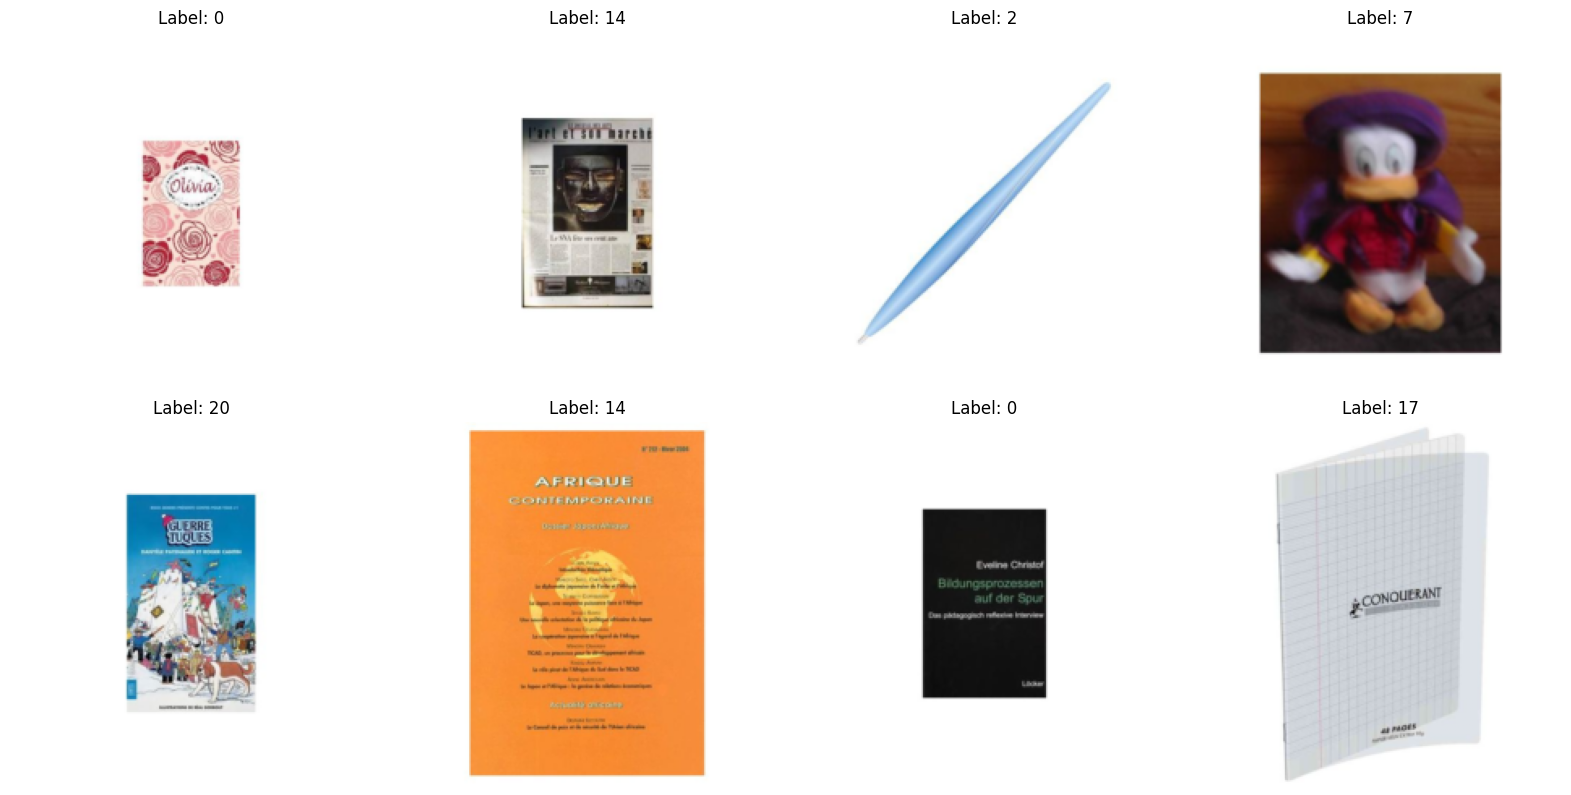

✓ Visualization complete


In [5]:
# Denormalize function
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize ImageNet-normalized tensor for visualization."""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

# Visualize first 8 images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(min(8, len(images))):
    img = denormalize(images[i])
    img_np = img.permute(1, 2, 0).numpy()
    
    axes[i].imshow(img_np)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

### 1.5 Verify All Filepaths Exist

In [6]:
# Check all filepaths in the dataset
missing_count = 0
existing_count = 0

for idx in range(len(dataset)):
    row = dataset.dataframe.iloc[idx]
    image_path = dataset._construct_image_path(row['imageid'], row['productid'])
    
    if image_path.exists():
        existing_count += 1
    else:
        missing_count += 1
        print(f"⚠ Missing: {image_path}")

print(f"\n✓ Filepath verification complete")
print(f"  Existing: {existing_count} / {len(dataset)}")
print(f"  Missing: {missing_count} / {len(dataset)}")

if missing_count == 0:
    print("  ✅ All images exist!")
else:
    print(f"  ⚠ {missing_count} images missing (should have been filtered)")


✓ Filepath verification complete
  Existing: 64 / 64
  Missing: 0 / 64
  ✅ All images exist!


### 1.6 Check Label Distribution

Label distribution in test subset:
    label  count  percentage
0      10      3        4.69
1      40      4        6.25
2      50      1        1.56
3      60      1        1.56
4    1140      2        3.12
5    1160      2        3.12
6    1180      2        3.12
7    1280      7       10.94
8    1281      4        6.25
9    1300      3        4.69
10   1320      1        1.56
11   1560      4        6.25
12   1920      3        4.69
13   2060      3        4.69
14   2280      5        7.81


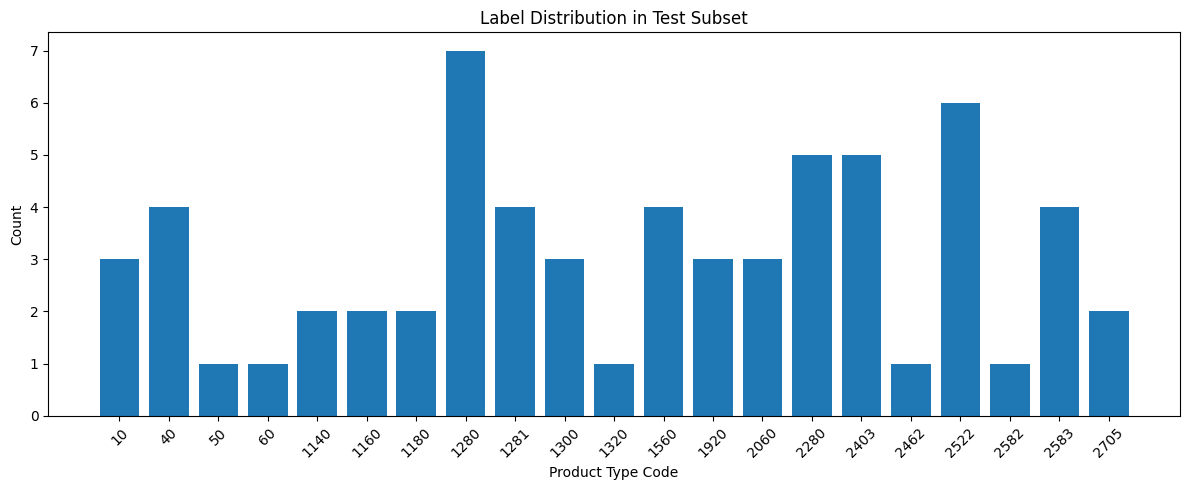


✓ Dataset sanity test PASSED


In [7]:
# Get label distribution
label_dist = dataset.get_label_distribution()
print("Label distribution in test subset:")
print(label_dist.head(15))

# Visualize
plt.figure(figsize=(12, 5))
plt.bar(label_dist['label'].astype(str), label_dist['count'])
plt.xlabel('Product Type Code')
plt.ylabel('Count')
plt.title('Label Distribution in Test Subset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n✓ Dataset sanity test PASSED")

---

## 2. Model Forward Pass Tests

**Objective:** Verify all models can perform forward passes correctly.

In [8]:
# Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = dataset.num_classes
batch_size = 16

# Get a test batch
test_images, test_labels = next(iter(test_loader))
test_images = test_images.to(device)
test_labels = test_labels.to(device)

print(f"Test batch shape: {test_images.shape}")
print(f"Device: {device}")
print(f"Number of classes: {num_classes}")

Test batch shape: torch.Size([16, 3, 224, 224])
Device: cuda
Number of classes: 21


### 2.1 Test ResNet50Classifier

In [9]:
print("=" * 60)
print("Testing ResNet50Classifier")
print("=" * 60)

# Create model
resnet_model = ResNet50Classifier(num_classes=num_classes, freeze_backbone=True)
resnet_model = resnet_model.to(device)
resnet_model.eval()

# Forward pass
with torch.no_grad():
    outputs = resnet_model(test_images)

print(f"\n✓ Forward pass successful")
print(f"  Input shape: {test_images.shape}")
print(f"  Output shape: {outputs.shape}")
print(f"  Expected shape: ({batch_size}, {num_classes})")

# Verify output shape
assert outputs.shape == (test_images.shape[0], num_classes), "Output shape mismatch!"
print("  ✅ Shape verification PASSED")

# Check logits
probs = torch.softmax(outputs, dim=1)
print(f"\n  Probability sum (should be ~1.0): {probs.sum(dim=1).mean():.4f}")
print(f"  Predicted classes: {outputs.argmax(dim=1).tolist()[:5]}...")

# Count parameters
total_params = sum(p.numel() for p in resnet_model.parameters())
trainable_params = sum(p.numel() for p in resnet_model.parameters() if p.requires_grad)
print(f"\n  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

del resnet_model
torch.cuda.empty_cache()
print("\n✓ ResNet50Classifier test PASSED\n")

Testing ResNet50Classifier
✓ ResNet50Classifier initialized: 21 classes, backbone frozen

✓ Forward pass successful
  Input shape: torch.Size([16, 3, 224, 224])
  Output shape: torch.Size([16, 21])
  Expected shape: (16, 21)
  ✅ Shape verification PASSED

  Probability sum (should be ~1.0): 1.0000
  Predicted classes: [19, 19, 19, 19, 19]...

  Total parameters: 24,568,917
  Trainable parameters: 1,060,885

✓ ResNet50Classifier test PASSED



### 2.2 Test ViTClassifier

In [10]:
print("=" * 60)
print("Testing ViTClassifier")
print("=" * 60)

# Create model
vit_model = ViTClassifier(num_classes=num_classes, freeze_backbone=True)
vit_model = vit_model.to(device)
vit_model.eval()

# Forward pass
with torch.no_grad():
    outputs = vit_model(test_images)

print(f"\n✓ Forward pass successful")
print(f"  Input shape: {test_images.shape}")
print(f"  Output shape: {outputs.shape}")
print(f"  Expected shape: ({batch_size}, {num_classes})")

assert outputs.shape == (test_images.shape[0], num_classes), "Output shape mismatch!"
print("  ✅ Shape verification PASSED")

probs = torch.softmax(outputs, dim=1)
print(f"\n  Probability sum: {probs.sum(dim=1).mean():.4f}")
print(f"  Predicted classes: {outputs.argmax(dim=1).tolist()[:5]}...")

total_params = sum(p.numel() for p in vit_model.parameters())
trainable_params = sum(p.numel() for p in vit_model.parameters() if p.requires_grad)
print(f"\n  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

del vit_model
torch.cuda.empty_cache()
print("\n✓ ViTClassifier test PASSED\n")

Testing ViTClassifier
✓ Using torchvision ViT-B/16
✓ ViTClassifier initialized: 21 classes, backbone frozen

✓ Forward pass successful
  Input shape: torch.Size([16, 3, 224, 224])
  Output shape: torch.Size([16, 21])
  Expected shape: (16, 21)
  ✅ Shape verification PASSED

  Probability sum: 1.0000
  Predicted classes: [3, 12, 12, 11, 12]...

  Total parameters: 86,204,181
  Trainable parameters: 405,525

✓ ViTClassifier test PASSED



### 2.3 Test FusionClassifier (Standard)

In [11]:
print("=" * 60)
print("Testing FusionClassifier (Standard)")
print("=" * 60)

try:
    # Create model
    fusion_model = FusionClassifier(num_classes=num_classes, freeze_backbones=True)
    fusion_model = fusion_model.to(device)
    fusion_model.eval()
    
    # Forward pass
    with torch.no_grad():
        outputs = fusion_model(test_images)
    
    print(f"\n✓ Forward pass successful")
    print(f"  Input shape: {test_images.shape}")
    print(f"  Output shape: {outputs.shape}")
    
    assert outputs.shape == (test_images.shape[0], num_classes), "Output shape mismatch!"
    print("  ✅ Shape verification PASSED")
    
    total_params = sum(p.numel() for p in fusion_model.parameters())
    trainable_params = sum(p.numel() for p in fusion_model.parameters() if p.requires_grad)
    print(f"\n  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    
    del fusion_model
    torch.cuda.empty_cache()
    print("\n✓ FusionClassifier test PASSED\n")
    
except RuntimeError as e:
    if "out of memory" in str(e):
        print("\n⚠ CUDA OOM: FusionClassifier too large for current batch size")
        print("  → Use LightweightFusionClassifier instead")
    else:
        raise e

Testing FusionClassifier (Standard)
✓ Using torchvision ViT-B/16 for fusion
✓ FusionClassifier initialized: 21 classes
  ResNet features: 2048, ViT features: 768, Fused: 2816
  Backbones frozen

✓ Forward pass successful
  Input shape: torch.Size([16, 3, 224, 224])
  Output shape: torch.Size([16, 21])
  ✅ Shape verification PASSED

  Total parameters: 112,729,941
  Trainable parameters: 3,423,253

✓ FusionClassifier test PASSED



### 2.4 Test LightweightFusionClassifier (Recommended for 8GB VRAM)

In [12]:
print("=" * 60)
print("Testing LightweightFusionClassifier")
print("=" * 60)

# Create model
lite_fusion_model = LightweightFusionClassifier(num_classes=num_classes, freeze_backbones=True)
lite_fusion_model = lite_fusion_model.to(device)
lite_fusion_model.eval()

# Forward pass
with torch.no_grad():
    outputs = lite_fusion_model(test_images)

print(f"\n✓ Forward pass successful")
print(f"  Input shape: {test_images.shape}")
print(f"  Output shape: {outputs.shape}")

assert outputs.shape == (test_images.shape[0], num_classes), "Output shape mismatch!"
print("  ✅ Shape verification PASSED")

total_params = sum(p.numel() for p in lite_fusion_model.parameters())
trainable_params = sum(p.numel() for p in lite_fusion_model.parameters() if p.requires_grad)
print(f"\n  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

del lite_fusion_model
torch.cuda.empty_cache()
print("\n✓ LightweightFusionClassifier test PASSED\n")

Testing LightweightFusionClassifier
✓ Using torchvision ViT-B/16 for lightweight fusion
✓ LightweightFusionClassifier initialized: 21 classes
  ResNet proj: 2048 -> 512, ViT proj: 768 -> 256, fused: 768

✓ Forward pass successful
  Input shape: torch.Size([16, 3, 224, 224])
  Output shape: torch.Size([16, 21])
  ✅ Shape verification PASSED

  Total parameters: 110,959,701
  Trainable parameters: 1,653,013

✓ LightweightFusionClassifier test PASSED



---

## 3. Short Training Dry-Run

**Objective:** Run 1-2 epochs to verify training loop, AMP, checkpointing, and early stopping.

### 3.1 Prepare Training Data

In [13]:
# Use a larger subset for dry-run (500 samples)
df_dryrun = df_full.head(500).copy()

# Split into train/val
train_size = int(0.8 * len(df_dryrun))
train_df = df_dryrun.iloc[:train_size].reset_index(drop=True)
val_df = df_dryrun.iloc[train_size:].reset_index(drop=True)

print(f"Dry-run dataset:")
print(f"  Train: {len(train_df)} samples")
print(f"  Val: {len(val_df)} samples")

# Create datasets
train_transform = get_train_transforms(img_size=224, augment=True)
val_transform = get_val_transforms(img_size=224)

train_dataset_dry = RakutenImageDataset(
    dataframe=train_df,
    image_dir=image_dir,
    transform=train_transform,
    verify_images=True,
    remove_missing=True
)

val_dataset_dry = RakutenImageDataset(
    dataframe=val_df,
    image_dir=image_dir,
    transform=val_transform,
    verify_images=True,
    remove_missing=True
)

# Create loaders
train_loader_dry = DataLoader(
    train_dataset_dry,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

val_loader_dry = DataLoader(
    val_dataset_dry,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

print(f"\n✓ Dry-run data ready")
print(f"  Train batches: {len(train_loader_dry)}")
print(f"  Val batches: {len(val_loader_dry)}")

Dry-run dataset:
  Train: 400 samples
  Val: 100 samples
✓ Created label mapping: 27 classes
  Example labels: [np.int64(10), np.int64(40), np.int64(50), np.int64(60), np.int64(1140)] ...
Verifying image files...
✓ All 400 images verified successfully
✓ RakutenImageDataset initialized: 400 samples, 27 classes
✓ Created label mapping: 23 classes
  Example labels: [np.int64(10), np.int64(40), np.int64(50), np.int64(1140), np.int64(1160)] ...
Verifying image files...
✓ All 100 images verified successfully
✓ RakutenImageDataset initialized: 100 samples, 23 classes

✓ Dry-run data ready
  Train batches: 12
  Val batches: 4


### 3.2 Run Dry-Run Training (2 epochs)

In [14]:
print("=" * 60)
print("Starting Dry-Run Training")
print("=" * 60)

# IMPORTANT: Use num_classes from train_dataset_dry, not from earlier test dataset
num_classes_train = train_dataset_dry.num_classes
print(f"Training with {num_classes_train} classes (from train_dataset_dry)")

# Create model with correct number of classes
model_dry = ResNet50Classifier(num_classes=num_classes_train, freeze_backbone=True)
model_dry = model_dry.to(device)

# Get class weights from training dataset
class_weights = train_dataset_dry.get_class_weights()
class_weights = class_weights.to(device)

print(f"✓ Model initialized: {num_classes_train} classes")
print(f"✓ Class weights computed: shape {class_weights.shape}")

# Verify shapes match
assert class_weights.shape[0] == num_classes_train, f"Shape mismatch: weights={class_weights.shape[0]}, model={num_classes_train}"
print("✓ Shape verification passed")

# Run training
history = train(
    model=model_dry,
    train_loader=train_loader_dry,
    val_loader=val_loader_dry,
    num_epochs=2,  # Only 2 epochs for dry-run
    learning_rate=1e-4,
    device=device,
    checkpoint_dir='../../checkpoints/dry_run',
    early_stopping_patience=5,
    use_amp=True,
    class_weights=class_weights
)

print("\n✓ Dry-run training completed")

Starting Dry-Run Training
Training with 27 classes (from train_dataset_dry)
✓ ResNet50Classifier initialized: 27 classes, backbone frozen


/usr/local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/workspace/src/rakuten_image/train.py:240: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device == 'cuda'))


✓ Model initialized: 27 classes
✓ Class weights computed: shape torch.Size([27])
✓ Shape verification passed
✓ Using weighted CrossEntropyLoss for class imbalance

Starting Training
Device: cuda
Mixed Precision (AMP): True
Epochs: 2
Learning Rate: 0.0001
Early Stopping Patience: 5
Checkpoint Directory: ../../checkpoints/dry_run



Epoch 1 [Train]:   0%|          | 0/12 [00:00<?, ?it/s]/workspace/src/rakuten_image/train.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]                                    /workspace/src/rakuten_image/train.py:152: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/2] (1.7s) | Train Loss: 3.4530, Train Acc: 4.69% | Val Loss: 3.3552, Val Acc: 3.00% | LR: 1.00e-04
✓ Checkpoint saved: ../../checkpoints/dry_run/best_model.pth (Epoch 1, Val Loss: 3.3552, Val Acc: 3.0000)


Epoch [2/2] (1.6s) | Train Loss: 3.0570, Train Acc: 13.80% | Val Loss: 3.3414, Val Acc: 5.00% | LR: 1.00e-04
✓ Checkpoint saved: ../../checkpoints/dry_run/best_model.pth (Epoch 2, Val Loss: 3.3414, Val Acc: 5.0000)

Training Completed!
Best Validation Loss: 3.3414
Best Model Saved: ../../checkpoints/dry_run/best_model.pth


✓ Dry-run training completed


### 3.3 Verify Checkpoints Were Saved

In [15]:
checkpoint_dir = Path('../../checkpoints/dry_run')

if checkpoint_dir.exists():
    checkpoints = list(checkpoint_dir.glob('*.pth'))
    print(f"✓ Checkpoints found: {len(checkpoints)}")
    for cp in checkpoints:
        size_mb = cp.stat().st_size / 1e6
        print(f"  - {cp.name} ({size_mb:.2f} MB)")
    
    # Load best checkpoint
    from src.rakuten_image.utils import load_checkpoint
    
    best_checkpoint = checkpoint_dir / 'best_model.pth'
    if best_checkpoint.exists():
        info = load_checkpoint(
            filepath=str(best_checkpoint),
            model=model_dry,
            device=device
        )
        print(f"\n✓ Best checkpoint loaded successfully")
        print(f"  Epoch: {info['epoch']}")
        print(f"  Val Loss: {info['val_loss']:.4f}")
        print(f"  Val Acc: {info['val_acc']:.2f}%")
else:
    print("⚠ No checkpoint directory found")

✓ Checkpoints found: 1
  - best_model.pth (107.13 MB)
✓ Checkpoint loaded: ../../checkpoints/dry_run/best_model.pth (Epoch 2, Val Loss: 3.3414, Val Acc: 5.0000)

✓ Best checkpoint loaded successfully
  Epoch: 2
  Val Loss: 3.3414
  Val Acc: 5.00%


/workspace/src/rakuten_image/utils.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=device)


### 3.4 Plot Training History

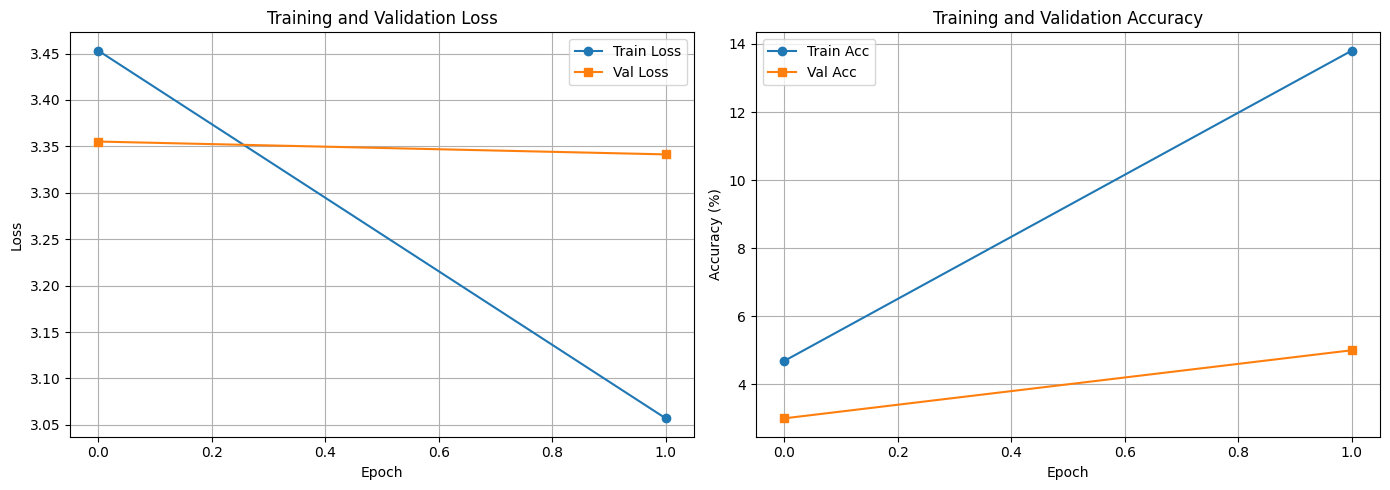


✓ Training dry-run test PASSED


In [16]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\n✓ Training dry-run test PASSED")

---

## 4. VRAM Profiling for RTX 3060 Ti

**Objective:** Determine optimal batch sizes for each model.

In [17]:
if not torch.cuda.is_available():
    print("⚠ Skipping VRAM profiling (no GPU detected)")
else:
    import gc
    
    def profile_vram(model_class, model_name, batch_sizes=[16, 32, 64, 96], **kwargs):
        """Profile VRAM usage for different batch sizes."""
        print(f"\n{'='*60}")
        print(f"Profiling: {model_name}")
        print(f"{'='*60}")
        
        results = []
        
        for bs in batch_sizes:
            try:
                # Clear cache
                torch.cuda.empty_cache()
                gc.collect()
                
                # Create model
                model = model_class(num_classes=num_classes, **kwargs)
                model = model.to(device)
                model.train()  # Training mode
                
                # Create dummy batch
                dummy_input = torch.randn(bs, 3, 224, 224, device=device)
                dummy_labels = torch.randint(0, num_classes, (bs,), device=device)
                
                # Forward + backward pass
                criterion = torch.nn.CrossEntropyLoss()
                
                with torch.cuda.amp.autocast():
                    outputs = model(dummy_input)
                    loss = criterion(outputs, dummy_labels)
                
                loss.backward()
                
                # Measure VRAM
                vram_used = torch.cuda.max_memory_allocated() / 1e9
                torch.cuda.reset_peak_memory_stats()
                
                results.append((bs, vram_used, "✓"))
                print(f"  Batch {bs:3d}: {vram_used:.2f} GB ✓")
                
                # Cleanup
                del model, dummy_input, dummy_labels, outputs, loss
                torch.cuda.empty_cache()
                
            except RuntimeError as e:
                if "out of memory" in str(e):
                    results.append((bs, None, "OOM"))
                    print(f"  Batch {bs:3d}: OOM ✗")
                    torch.cuda.empty_cache()
                    break
                else:
                    raise e
        
        return results
    
    # Profile each model
    vram_results = {}
    
    vram_results['ResNet50'] = profile_vram(
        ResNet50Classifier, "ResNet50", freeze_backbone=True
    )
    
    vram_results['ViT'] = profile_vram(
        ViTClassifier, "ViT", freeze_backbone=True
    )
    
    vram_results['LightweightFusion'] = profile_vram(
        LightweightFusionClassifier, "Lightweight Fusion", freeze_backbones=True
    )


Profiling: ResNet50
✓ ResNet50Classifier initialized: 21 classes, backbone frozen
  Batch  16: 0.64 GB ✓


/tmp/ipykernel_3823/2209325744.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✓ ResNet50Classifier initialized: 21 classes, backbone frozen
  Batch  32: 0.43 GB ✓
✓ ResNet50Classifier initialized: 21 classes, backbone frozen
  Batch  64: 0.63 GB ✓
✓ ResNet50Classifier initialized: 21 classes, backbone frozen
  Batch  96: 0.83 GB ✓

Profiling: ViT
✓ Using torchvision ViT-B/16
✓ ViTClassifier initialized: 21 classes, backbone frozen
  Batch  16: 0.57 GB ✓
✓ Using torchvision ViT-B/16
✓ ViTClassifier initialized: 21 classes, backbone frozen
  Batch  32: 0.67 GB ✓
✓ Using torchvision ViT-B/16
✓ ViTClassifier initialized: 21 classes, backbone frozen
  Batch  64: 0.86 GB ✓
✓ Using torchvision ViT-B/16
✓ ViTClassifier initialized: 21 classes, backbone frozen
  Batch  96: 1.06 GB ✓

Profiling: Lightweight Fusion
✓ Using torchvision ViT-B/16 for lightweight fusion
✓ LightweightFusionClassifier initialized: 21 classes
  ResNet proj: 2048 -> 512, ViT proj: 768 -> 256, fused: 768
  Batch  16: 0.68 GB ✓
✓ Using torchvision ViT-B/16 for lightweight fusion
✓ LightweightFusionC

### 4.1 VRAM Profiling Summary

In [18]:
if torch.cuda.is_available():
    print("\n" + "=" * 60)
    print("VRAM Profiling Summary (RTX 3060 Ti - 8GB)")
    print("=" * 60)
    
    for model_name, results in vram_results.items():
        print(f"\n{model_name}:")
        
        # Find max safe batch size
        safe_batches = [bs for bs, vram, status in results if status == "✓" and vram is not None]
        
        if safe_batches:
            max_safe_bs = max(safe_batches)
            max_vram = [vram for bs, vram, status in results if bs == max_safe_bs][0]
            
            print(f"  Recommended batch size: {max_safe_bs}")
            print(f"  VRAM usage @ batch {max_safe_bs}: {max_vram:.2f} GB")
            print(f"  Safety margin: {8 - max_vram:.2f} GB")
        else:
            print(f"  ⚠ All batch sizes caused OOM")
    
    print("\n" + "=" * 60)
    print("Recommendations for RTX 3060 Ti (8GB):")
    print("=" * 60)
    print("  ResNet50: Batch size 64 (with AMP)")
    print("  ViT: Batch size 32-48 (with AMP)")
    print("  LightweightFusion: Batch size 24-32 (with AMP)")
    print("  Standard Fusion: Batch size 16-24 (with AMP) or use Lightweight variant")
    print("\n  ⚠ Always use use_amp=True to maximize batch size!")
    print("=" * 60)


VRAM Profiling Summary (RTX 3060 Ti - 8GB)

ResNet50:
  Recommended batch size: 96
  VRAM usage @ batch 96: 0.83 GB
  Safety margin: 7.17 GB

ViT:
  Recommended batch size: 96
  VRAM usage @ batch 96: 1.06 GB
  Safety margin: 6.94 GB

LightweightFusion:
  Recommended batch size: 96
  VRAM usage @ batch 96: 1.18 GB
  Safety margin: 6.82 GB

Recommendations for RTX 3060 Ti (8GB):
  ResNet50: Batch size 64 (with AMP)
  ViT: Batch size 32-48 (with AMP)
  LightweightFusion: Batch size 24-32 (with AMP)
  Standard Fusion: Batch size 16-24 (with AMP) or use Lightweight variant

  ⚠ Always use use_amp=True to maximize batch size!


---

## 5. Recommended Production Workflow

**Two-Phase Training Strategy**

### Phase 1: Transfer Learning (Frozen Backbone)

```python
# Train with frozen backbone (fast, prevents catastrophic forgetting)
model = ResNet50Classifier(num_classes=27, freeze_backbone=True)
model = model.to('cuda')

history_phase1 = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=20,
    learning_rate=1e-4,  # Standard LR
    device='cuda',
    checkpoint_dir='checkpoints/phase1',
    early_stopping_patience=5,
    use_amp=True
)
```

**Expected Results:**
- Converges in 10-15 epochs
- Val accuracy: ~60-70%
- Fast training (backbone frozen)

---

### Phase 2: Fine-Tuning (Unfrozen Backbone)

```python
# Load best checkpoint from Phase 1
from src.rakuten_image.utils import load_checkpoint

load_checkpoint(
    filepath='checkpoints/phase1/best_model.pth',
    model=model,
    device='cuda'
)

# Unfreeze backbone
model.unfreeze_backbone()

# Fine-tune with MUCH LOWER learning rate
history_phase2 = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=15,
    learning_rate=1e-5,  # 10x lower LR
    device='cuda',
    checkpoint_dir='checkpoints/phase2',
    early_stopping_patience=7,
    use_amp=True
)
```

**Expected Results:**
- Improves by 5-10% over Phase 1
- Val accuracy: ~70-80%
- Slower training (full backprop)

---

### Integration with Multimodal Pipeline

After training image models, integrate with text pipeline:

```python
# 1. Extract image embeddings
model.eval()
with torch.no_grad():
    image_features = model.get_features(images)  # (B, 2048)

# 2. Load text embeddings from rakuten_text pipeline
# text_features = ...  # (B, text_dim)

# 3. Concatenate for multimodal fusion
# multimodal_features = torch.cat([image_features, text_features], dim=1)

# 4. Train final multimodal classifier
# ...
```

---

## 6. Final Checklist

Before running full training, ensure:

- ✅ Dataset loads correctly (no missing images)
- ✅ Label mapping is correct (27 classes for Rakuten)
- ✅ All models can forward pass without errors
- ✅ Checkpointing works
- ✅ Training loop completes (dry-run passed)
- ✅ VRAM usage is within 8GB limit
- ✅ Batch size is optimized for your GPU
- ✅ AMP is enabled (use_amp=True)

**You're ready for production training!**

In [19]:
print("\n" + "=" * 70)
print("VALIDATION COMPLETE")
print("=" * 70)
print("✅ All tests passed!")
print("✅ Library is ready for production use")
print("=" * 70)


VALIDATION COMPLETE
✅ All tests passed!
✅ Library is ready for production use


---

## 7. Test ViT HuggingFace (google/vit-base-patch16-224)

**Objectif:** Tester l'intégration du modèle ViT de HuggingFace avec les meilleures pratiques.

**Configuration:**
- Modèle: google/vit-base-patch16-224
- Optimizer: AdamW (torch.optim)
- Scheduler: Linear avec Warmup
- Image Size: 224x224
- Normalization: mean=0.5, std=0.5

In [20]:
import sys
import os
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from sklearn.metrics import classification_report

# ------------------------------------------------------------------
# 1. Vérification des bibliothèques & Chemins (Environment Setup)
# ------------------------------------------------------------------
try:
    from transformers import ViTForImageClassification, get_scheduler
    from torch.optim import AdamW  # IMPORTANT: AdamW est maintenant dans torch.optim
    print("✓ Tous les modules importés avec succès")
except ImportError as e:
    print(f"❌ Erreur d'import: {e}")
    print("Exécutez : pip install transformers")
    raise

# Ajout du dossier 'src' au path si nécessaire
current_dir = os.getcwd()
project_root = Path(current_dir).parent.parent
if (project_root / "src").is_dir():
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    print(f"✅ Racine du projet trouvée : {project_root}")

try:
    from src.rakuten_image.datasets import RakutenImageDataset
    print("✓ RakutenImageDataset importé avec succès")
except ImportError as e:
    print(f"❌ Impossible d'importer RakutenImageDataset: {e}")
    raise

# ------------------------------------------------------------------
# 2. Configuration & Chargement des Données (Data Loading)
# ------------------------------------------------------------------
DATA_DIR = Path("../../data")
IMG_DIR = Path("../../data/images/image_train")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuration ViT (CRITIQUE : Ne pas changer ces valeurs)
VIT_IMG_SIZE = 224      # ViT a besoin de 224x224
BATCH_SIZE = 16         # 16 pour être sûr (32 peut passer sur 3060 Ti)
EPOCHS = 3              # Nombre d'epochs pour le test

print(f"\n🔄 Chargement des données depuis {DATA_DIR}...")
print(f"Device: {DEVICE}")

# Réutilise df_full si disponible, sinon recharge
if 'df_full' in locals() and isinstance(df_full, pd.DataFrame):
    df = df_full.copy()
    print(f"✅ Utilisation du DataFrame en mémoire : {len(df)} lignes.")
else:
    try:
        X_train = pd.read_csv(DATA_DIR / "X_train_update.csv", index_col=0)
        Y_train = pd.read_csv(DATA_DIR / "Y_train_CVw08PX.csv", index_col=0)
        df = X_train.join(Y_train, how="inner")
        print(f"✅ Données chargées depuis CSV : {len(df)} lignes.")
    except FileNotFoundError as e:
        print(f"❌ Fichiers CSV introuvables: {e}")
        raise

# Transformation spécifique pour ViT (Mean/Std 0.5)
vit_transform = transforms.Compose([
    transforms.Resize((VIT_IMG_SIZE, VIT_IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Création du Dataset et DataLoader
print("Creating dataset...")
vit_dataset = RakutenImageDataset(
    dataframe=df,
    image_dir=IMG_DIR,
    transform=vit_transform,
    label_col="prdtypecode",
    verify_images=False
)

print(f"✓ Dataset créé: {len(vit_dataset)} échantillons, {vit_dataset.num_classes} classes")

vit_loader = DataLoader(
    vit_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

print(f"✓ DataLoader créé: {len(vit_loader)} batches")

# ------------------------------------------------------------------
# 3. Chargement du Modèle ViT (Model Setup)
# ------------------------------------------------------------------
print(f"\n🏗️ Construction du modèle ViT sur {DEVICE}...")
model_name = "google/vit-base-patch16-224"

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=vit_dataset.num_classes,
    ignore_mismatched_sizes=True
)
model.to(DEVICE)
print(f"✓ Modèle ViT chargé: {vit_dataset.num_classes} classes")

# ------------------------------------------------------------------
# 4. Optimiseur & Scheduler 
# ------------------------------------------------------------------
# AdamW avec Weight Decay pour régulariser
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
print(f"✓ Optimizer AdamW configuré (lr=2e-5, weight_decay=0.01)")

# Scheduler avec Warmup (10% du temps total)
total_steps = len(vit_loader) * EPOCHS
num_warmup_steps = int(total_steps * 0.1)

scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)
print(f"✓ Scheduler configuré (warmup: {num_warmup_steps}/{total_steps} steps)")

# ------------------------------------------------------------------
# 5. Boucle d'Entraînement 
# ------------------------------------------------------------------
print(f"\n🚀 Démarrage de l'entraînement (Dry-Run : {EPOCHS} Epochs)...")
print("=" * 70)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for i, (images, labels) in enumerate(vit_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Forward pass (HuggingFace calcule la loss automatiquement)
        outputs = model(pixel_values=images, labels=labels)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient Clipping (Évite les gradients explosifs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Log progress
        if (i + 1) % 20 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"  Epoch [{epoch+1}/{EPOCHS}] Batch [{i+1}/{len(vit_loader)}] "
                  f"Loss: {loss.item():.4f} | LR: {current_lr:.2e}")

        # --- LIMITATION POUR LE TEST (Dry-Run) ---
        # Supprimez les 2 lignes ci-dessous pour l'entraînement complet
        if i >= 50:
            print("  🛑 Arrêt rapide (Dry-run limit reached).")
            break
        # -----------------------------------------

    avg_loss = total_loss / (i + 1) # i+1 car on a peut-être breaké
    print(f"🏁 Epoch {epoch+1} terminé. Loss moyen : {avg_loss:.4f}")

# ------------------------------------------------------------------
# 6. Évaluation Rapide
# ------------------------------------------------------------------
print(f"\n📊 Évaluation rapide (sur un sous-ensemble)...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for i, (images, labels) in enumerate(vit_loader):
        images = images.to(DEVICE)
        outputs = model(pixel_values=images)
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

        # On évalue seulement sur 10 batchs pour aller vite
        if i >= 10: break

print("\n" + "="*60)
# 'digits=4' pour voir les détails précis
print(classification_report(all_labels, all_preds, digits=4, zero_division=0))
print("="*60)
print("✅ Test ViT terminé avec succès.")

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Tous les modules importés avec succès
✅ Racine du projet trouvée : /workspace
✓ RakutenImageDataset importé avec succès

🔄 Chargement des données depuis ../../data...
Device: cuda
✅ Utilisation du DataFrame en mémoire : 84916 lignes.
Creating dataset...
✓ Created label mapping: 27 classes
  Example labels: [np.int64(10), np.int64(40), np.int64(50), np.int64(60), np.int64(1140)] ...
✓ RakutenImageDataset initialized: 84916 samples, 27 classes
✓ Dataset créé: 84916 échantillons, 27 classes
✓ DataLoader créé: 5308 batches

🏗️ Construction du modèle ViT sur cuda...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([27]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([27, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Modèle ViT chargé: 27 classes
✓ Optimizer AdamW configuré (lr=2e-5, weight_decay=0.01)
✓ Scheduler configuré (warmup: 1592/15924 steps)

🚀 Démarrage de l'entraînement (Dry-Run : 3 Epochs)...
  Epoch [1/3] Batch [20/5308] Loss: 3.4245 | LR: 2.51e-07
  Epoch [1/3] Batch [40/5308] Loss: 3.1794 | LR: 5.03e-07
  🛑 Arrêt rapide (Dry-run limit reached).
🏁 Epoch 1 terminé. Loss moyen : 3.4186
  Epoch [2/3] Batch [20/5308] Loss: 3.2915 | LR: 8.92e-07
  Epoch [2/3] Batch [40/5308] Loss: 3.5072 | LR: 1.14e-06
  🛑 Arrêt rapide (Dry-run limit reached).
🏁 Epoch 2 terminé. Loss moyen : 3.3947
  Epoch [3/3] Batch [20/5308] Loss: 3.1880 | LR: 1.53e-06
  Epoch [3/3] Batch [40/5308] Loss: 3.3387 | LR: 1.78e-06
  🛑 Arrêt rapide (Dry-run limit reached).
🏁 Epoch 3 terminé. Loss moyen : 3.3664

📊 Évaluation rapide (sur un sous-ensemble)...

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         6
           1     0.0000    0.0000    0.0000         2
     